# Lab 6 -  Intro to Convolutional Neural Networks

These laboratory excersises are solved on Google Colab and are save on GitHub repo that is connected to GitHub Classroom.

## Tools You need to use to Submit Assignments

In this document, you will solve tasks. This is a Jupyter Notebook which has the **.ipynb** extension, is an interactive web environment for data analysis, visualization, solution presentations, education, and more.

**Google Colab** is a tool that allows you to run and share Jupyter Notebook files on Google's servers, including the use of Google's CPU, GPU, and TPU resources. Colab is like Google Docs for Jupyter Notebooks. **Google Colab does not automatically save your assignment to GitHub.**

**You use GitHub to save and submit your assignments.** When you accept the assignment through GitHub Classroom, a repository is automatically created on your GitHub account with a copy of the task. This is where you will save your solutions. Saving your solutions submits the tasks for that lab.

## How to Solve the Tasks?
1. Accept the task via the Google Classroom link that you will receive. Google Classroom will create a repository on your account.
2. Go to the newly created repository on your account and click on the .ipynb file, then click Open in Colab.
3. You will solve the tasks in Google Colab.

## How to Save (Submit) Tasks?

1. In Google Colab, click on the Open settings gear icon in the top-right corner.
2. Click on the GitHub tab and check the box for Access private repositories and organizations.
3. A new window will open for you to grant access to GitHub. For ferit-osirv, click Grant.
4. Save and exit the settings.
5. Click on File > Save a copy in GitHub.
6. Select the lab repository that includes your name.

> *Note:* You only need to complete steps 1-4 the first time.

7. Click on **File > Save a copy in GitHub**.
8. Select created repository **koji uključuje vaše ime**.

# Introduction to CNNs

Convolutional neural networks (CNNs) are one of the largest revolutions in the computer vision field. They are the state of the art (SOTA) solution for problems like object detection, handwriting recognition, face recognition, and many other image processing tasks.

Traditional methods are still used for specific tasks and as preprocessing steps for CNNs, so don't forget everything you've learned so far. :)

You already used convolutions many times in these labs. In lab2 you wrote your own convolution code. In lab3 you used median filtering, a convolution with a specific kernel to blur the image. In lab4 you used a blur filter.

Depending on the used kernel, convolutions can achieve all kinds of different things: Show specific features like edges and corners, show and remove textures, etc.

Traditionally, when someone is working on an image processing task they would hand-select the kernel used in the convolution.

CNNs work similarly but take it all one step further. Instead of manually convolving the image with known kernels, in deep learning we let the network learn the kernels it's using. CNNs have multiple layers, in each layer, they perform lots and lots of convolutions with different kernels in parallel. Each layer's output is used as input for the next layer. By doing this, a CNN can learn more-and-more complex features deeper in the network. At first, it can detect lines and corners, in the later layers, it can combine lines to detect more complex shapes, and so on.

Follow along this notebook to find out how CNNs work.

## PyTorch and neural networks

For this lab, you'll use PyTorch, one of the most popular deep learning libraries to implement a convolutional neural network from scratch. For simple problems, you can use tools like [fastai](https://docs.fast.ai) which can automate a lot of this process for you. Still, it's good to be familiar with what lies beneath tools like that.

Begin by importing PyTorch and the TorchVision library, which has useful functions to work with images.

In [1]:
import torch
import torchvision

Next, we'll declare a couple of properties. Don't worry about these just yet.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

# Preparing our data

To train a neural network, we first need a lot of data. Neural networks learn by looking at example input images and their correct output. In your case that will be a bunch of handwritten digits and their correct translation into text.

You can look at a neural network as a math function, mapping inputs into outputs. By knowing the correct solution during training, a neural network can adjust what it does inside the function so that its output matches the correct solution.

For this problem, you'll use a popular dataset of handwritten digits called MNIST. Torchvision already includes a function to download the dataset.

You'll apply a transformation to each image. First, you'll convert the images to PyTorch Tensors. Tensors are _very_ similar to NumPy arrays, so you're already fairly familiar with them.

The other transformation you'll apply is normalization. Since neural networks work by multiplying and adding together a bunch of numbers, the absolute values of those numbers matter a lot. Multiplying 0.001 a bunch of times will give you a very small number at the end, making it very hard to work with. Similarly, multiplying huge numbers can be unstable too. It's best to map CNN inputs into a range of [-0.5, 0.5], making sure they're centered around 0. That's what the Normalize transform does.

You'll create two datasets, one for training and one for testing. It's very important that you do this step: You can't verify that your model works if you train and test the model on the same data, since it can in some cases learn to reproduce correct outputs on the training data by memorization, not understanding.

In [3]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_data = torchvision.datasets.MNIST('/files/', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data = torchvision.datasets.MNIST('/files/', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.43MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.18MB/s]


You also create a DataLoader for your dataset. NNs are usually trained in batches of inputs. Training the network one by one input is far too slow, but we also can't train on all of the inputs. That's why we specify a batch size of 64: During each training iteration, the network will receive 64 images. The DataLoader class does the batching for us.

Let's grab the first batch from the testing DataLoader:

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

Your example data has the following shape: (n_batches, n_channels, width, height). The batch size is specified when creating the DataLoader. The images themselves are very small and grayscale, which explains why they only have one channel.

**Question 1:** What is the shape of the _training_ loader's first batch?

Type your answer here.

Next, let's use matplotlib to plot a few examples of the images:

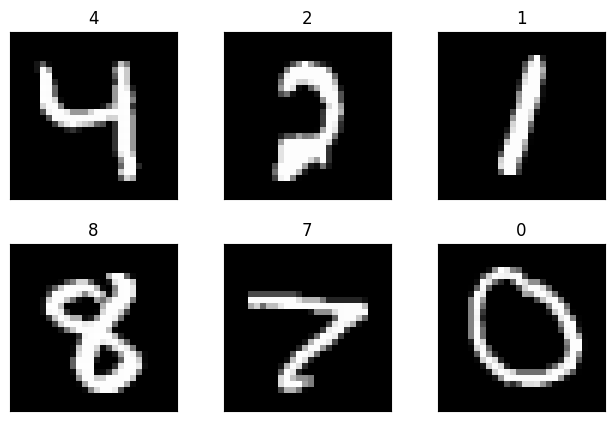

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(example_targets[i].item())
  plt.xticks([])
  plt.yticks([])

**Question 2**: You were tasked with training a NN for handwritten digit detection using this dataset. You will perform the detection on scanned (regular A4 printer) papers where the digits were typed inside boxes with a blue pen. Which preprocessing steps would you perform on your own inputs, knowing the network was trained on images like the ones above?

Type your answer here.

# CNN architecture

Now it's time to build the network. A CNN usually consists of convolutional layers, i.e. NN layers that perform a convolution on the input matrix and return the convolved matrix as output. You'll use two of these layers. You'll then use a dropout layer, which just randomly disables half of the features to prevent the network from memorizing the training dataset. Finally, you'll use two layers to combine all of the convolution results into just 10 numbers, the probability for each digit. Exactly how those layers are combined (whether they are summed, how much each layer contributes to the result for each digit, etc.) will be learned during training.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In the `__init__` of the class you create all the necessary layer objects that the network will use, but you just add them as properties, they don't do anything yet.

The `forward()` method is called every time the network receives a new output. `forward()`'s job is to calculate the output from the network and return it. What you'll do is pass the input to the first layer, and then pass the output of that layer to the next one, all the way until you get your 10 numbers. Finally, you'll use `log_softmax()` on those 10 numbers just to map them to probabilities from 0 to 1, and make sure they all add up to 1. There's no magic here, just high-school level math. :)

Next, we'll instantiate the network on the GPU:

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Net().to(device)

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Along with the network, we also instantiate an optimizer. The optimizer is in charge of training the network, more on that in the next section:

# Training

Now that you have a network, it's time to train it. Explained at a very high level, training works by first giving the model an input image, and the model gives us a resulting prediction in the form of 10 numbers, a probability for each digit. Naturally, this prediction is basically random at first. We then compare the model's output with the actual value (for the digit 3, it would be `[0, 0, 0, 1, 0, 0, ...]` - the probability of 1 on the 4th index of the array). The comparison is done with a function called the **loss** function, which measures how bad the model is. During training, our job is to **minimize the loss function**.

To minimize the loss, we simply need to shift the parameters of the network so that the loss goes down. We can know this if we calculate the gradient of the loss. You already know from math that the gradient measures the speed and direction of change. By taking the gradient of the loss function, we know if we need to increase or decrease our parameters to get a decrease of the loss.

That's where the optimizer comes in. PyTorch includes a bunch of different algorithms to minimize the loss function. They are in charge of increasing or decreasing the network's parameters so that the loss goes down. That's why the optimizer above receives the network's parameters: It needs to be able to change them.

The following function will be called during each **epoch** of training. An epoch is _one iteration through the whole training dataset_. In real-world applications, we use 100s of epochs, but in this example, only 3 are enough to achieve good results.

In [8]:
def train(epoch):
  # Set the network in training mode. This doesn't really do much, it's just
  # a flag that we set.
  network.train()
  # for each training batch in the train loader
  for batch_idx, data in enumerate(train_loader):
    # grab the training batch and copy it to the GPU
    # image - the input image
    # target - the correct output
    image, target = data[0].to(device), data[1].to(device)
    # first, set all gradients to zero
    optimizer.zero_grad()
    # calculate a prediction from the model
    output = network(image)
    # calculate the loss for this batch
    loss = F.nll_loss(output, target)
    # calculate the gradient of each part of the network,
    # and store it inside the tensors in the network
    loss.backward()
    # then use those gradients to nudge paramers so that the loss goes down
    optimizer.step()

    # this part doesn't perform training, it just gives us a progress report
    # and periodically saves our training result
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Once we're done with training, we're ready to test our network. We'll do this by giving the model our test data and taking all the predictions. We then compare the model's predictions with known correct outputs to calculate the model's accuracy.

In [9]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data in test_loader:
      image, target = data[0].to(device), data[1].to(device)
      output = network(image)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # our output gives us a probability for each digit, so we take the one
      # with the highest probability as our predicted digit
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

So far you only declared functions, it's time to use them. You'll set up a couple of variables to track the loss so that you can plot it later, and then train for three epochs, and test the model at the end of each epoch.

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipython-input-1255250890.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3064, Accuracy: 472/10000 (5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371357
Train Epoch: 1 [200/60000 (11%)]	Loss: 2.085780
Train Epoch: 1 [400/60000 (21%)]	Loss: 1.337303
Train Epoch: 1 [600/60000 (32%)]	Loss: 0.565167
Train Epoch: 1 [800/60000 (43%)]	Loss: 0.611202
Train Epoch: 1 [1000/60000 (53%)]	Loss: 0.778433
Train Epoch: 1 [1200/60000 (64%)]	Loss: 0.935946
Train Epoch: 1 [1400/60000 (75%)]	Loss: 0.681385
Train Epoch: 1 [1600/60000 (85%)]	Loss: 0.365029
Train Epoch: 1 [1800/60000 (96%)]	Loss: 0.634805

Test set: Avg. loss: 0.1972, Accuracy: 9434/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.537310
Train Epoch: 2 [200/60000 (11%)]	Loss: 0.189175
Train Epoch: 2 [400/60000 (21%)]	Loss: 0.566724
Train Epoch: 2 [600/60000 (32%)]	Loss: 0.492169
Train Epoch: 2 [800/60000 (43%)]	Loss: 0.461851
Train Epoch: 2 [1000/60000 (53%)]	Loss: 0.439068
Train Epoch: 2 [1200/60000 (64%)]	Loss: 0.316251
Train Epoch: 2 [1400/60000 (75%)]	Loss: 0.338885
Train Epoch: 2 [1600

Now you have a trained model!

# Evaluating the Model's Performance

Let's plot the training curve:

Text(0, 0.5, 'negative log likelihood loss')

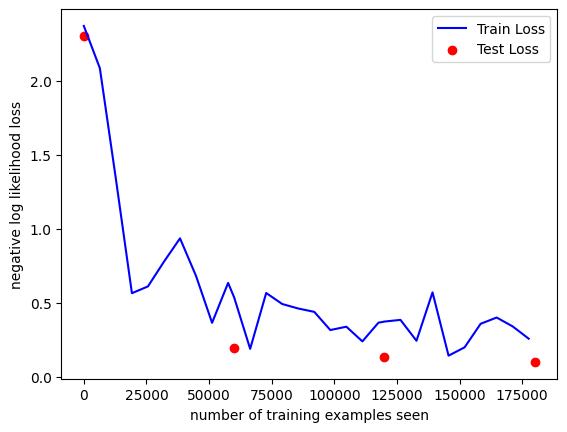

In [11]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

We get most of the training done right at the start, but going from 20% to 80% accuracy is easy. The closer we get to 100%, the harder it is to get additional accuracy.


Let's take a look at some examples:

In [12]:
with torch.no_grad():
  output = network(example_data.to(device))

/tmp/ipython-input-1255250890.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


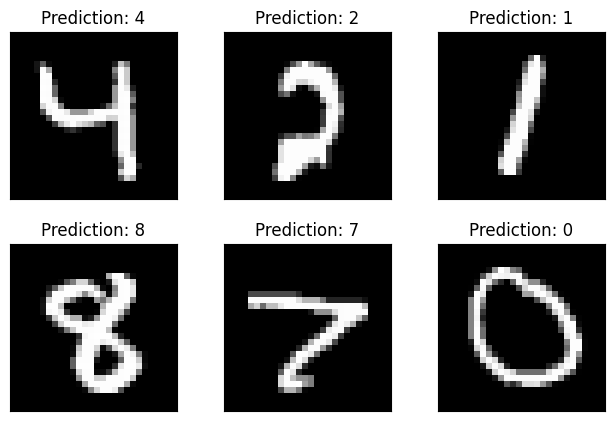

In [13]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

The model guesses the numbers correctly! Let's see the accuracy for each number:

In [14]:
classes = [str(i) for i in range(11)]
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/tmp/ipython-input-1255250890.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 96 %
Accuracy of     4 : 97 %
Accuracy of     5 : 97 %
Accuracy of     6 : 96 %
Accuracy of     7 : 95 %
Accuracy of     8 : 96 %
Accuracy of     9 : 95 %


**Question 3:** Which numbers have the worst accuracy? Can you guess why? Knowing the accuracy of the model is about 97%, would you say this is comparable to human-level accuracy for the same task?

Type your answer here.

# Single and multi-label classification with ResNets

## Introduction

In this lab, we will build on top of the CNNs introduced in the previous (lab7) and explain to you the ResNet (residual network) architecture. Although CNNs perform well, the limited amount of annotated data requires the development of efficient and more complex, deeper network architectures. Deep convolutional neural networks have shown a significant increase in the accuracy for various segmentation and classification tasks.

ResNet was introduced in 2015 by Kaiming He et al. in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385) and is by far the most used model architecture nowadays. More recent developments in image models almost always use the same trick of residual connections, and most of the time, they are just a tweak of the original ResNet.

We will first show you the basic ResNet as it was first designed, then explain to you what modern tweaks make it more performant.

### Deep Residual Networks (ResNets)

After the first CNN-based architecture (AlexNet) that win the ImageNet 2012 competition, every subsequent winning architecture uses more layers in a deep neural network to reduce the error rate. This works for less number of layers, but when we increase the number of layers, there is a common problem in deep learning associated with that called Vanishing/Exploding gradient. This causes the gradient to become 0 or too large. Thus when we increases number of layers, the training and test error rate also increases.

<p align="center">
  <img src="https://i.ibb.co/0n06TVs/resnet.png">
</p>


In the above plot, we can observe that a 56-layer CNN gives more error rate on both training and testing dataset than a 20-layer CNN architecture, If this was the result of over fitting, then we should have lower training error in 56-layer CNN but then it also has higher training error. After analyzing more on error rate the authors were able to reach conclusion that it is caused by vanishing/exploding gradient (as the depth of CNN increases, information about the gradient passes through many layers, and it can vanish or accumulate large errors by the time it reaches the end of the network).

### Residual Block

In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.

The approach behind this network is instead of layers learn the underlying mapping, we allow network fit the residual mapping. So, instead of say H(x), initial mapping, let the network fit, F(x)= H(x)–x which gives H(x)=F(x)+x.

<p align="center">
  <img src="https://i.ibb.co/cTkwsZt/residual-block.png">
</p>

The advantage of adding this type of skip connection is because if any layer hurt the performance of architecture then it will be skipped by regularization. So, this results in training very deep neural network without the problems caused by vanishing/exploding gradient.



### ResNet Network Architecture

The first ResNet architecture was the Resnet-34, which involved the insertion of shortcut connections in turning a plain network into its residual network counterpart. In this case, the plain network was inspired by VGG neural networks (VGG-16, VGG-19), with the convolutional networks having 3×3 filters. However, compared to VGGNets, ResNets have fewer filters and lower complexity. The 34-layer ResNet achieves a performance of 3.6 bn FLOPs, compared to 1.8bn FLOPs of smaller 18-layer ResNets.

It also followed two simple design rules –  the layers had the same number of filters for the same output feature map size, and the number of filters doubled in case the feature map size was halved in order to preserve the time complexity per layer. It consisted of 34 weighted layers.

The shortcut connections were added to this plain network. While the input and output dimensions were the same, the identity shortcuts were directly used. With an increase in the dimensions, there were two options to be considered. The first was that the shortcut would still perform identity mapping while extra zero entries would be padded for increasing dimensions. The other option was to use the projection shortcut to match dimensions. Comparison of plain network i ResNet is shown below:

<p align="center">
  <img src="https://i.ibb.co/kGFPw9M/resnet-vs-plain.png">
</p>

Various improvements of an original ResNet34 are developed through the years. One example is Resnet50 architecture which introduced one major difference. In the case of ResNet50, the building block was modified into a bottleneck design due to concerns over the time taken to train the layers. This used a stack of 3 layers instead of the earlier 2.

Therefore, each of the 2-layer blocks in Resnet34 was replaced with a 3-layer bottleneck block, forming the Resnet 50 architecture. This has much higher accuracy than the 34-layer ResNet model. The 50-layer ResNet achieves a performance of 3.8bn FLOPS!



Now we will implement ResNet34 and ResNet50 for the task of single and multiple label classification.

Training will take a lot of time, you may go and grab some coffee while waiting...

# Single lable classification

For this task, we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) that contains images of cats and dogs of 37 different breeds. We will first show how to build a simple cat-vs-dog classifier.

In [15]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [16]:
from fastai.vision.all import *

In [17]:
path = untar_data(URLs.PETS)

<div><progress max="811706944" value="811712512"></progress> 100.00% [811712512/811706944 00:15&lt;00:00]</div>

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the `.ls()` method.

In [18]:
path.ls()

[Path('/root/.fastai/data/oxford-iiit-pet/images'), Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

We will ignore the annotations folder for now, and focus on the images one. `get_image_files` is a fastai function that helps us grab all the image files (recursively) in one folder.

In [19]:
files = get_image_files(path/"images")
len(files)

7390

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs.

In [20]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_179.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_197.jpg'))

We can then define an easy label function:

In [21]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`.

In [22]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we're working in, the `files` we grabbed, our `label_func` and one last piece as `item_tfms`: this is a `Transform` applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would be impossible to batch the items together.

We can then check if everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

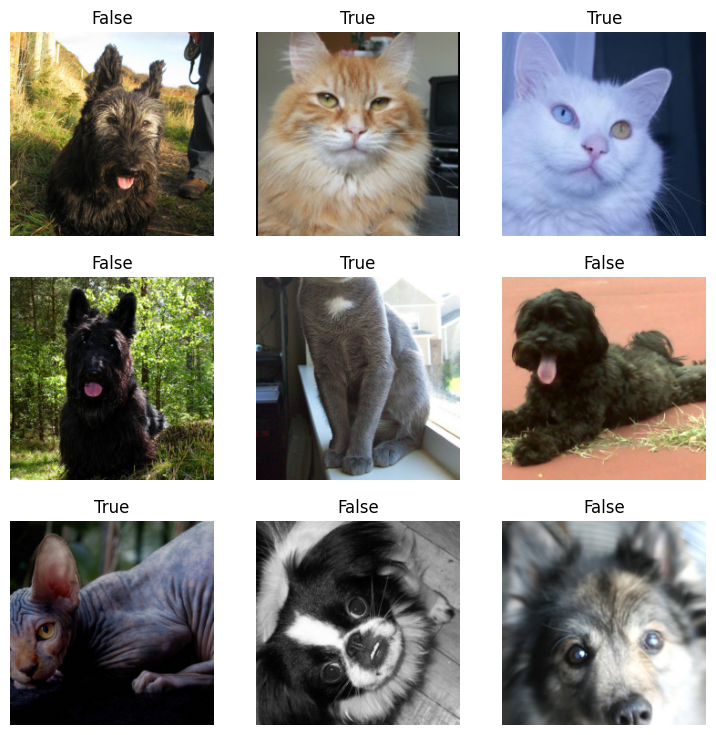

In [23]:
dls.show_batch()

Then we can create a `Learner`, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

The first line downloaded a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/), and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with an error rate of 0.3%... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [25]:
learn.predict(files[0])

epoch,train_loss,valid_loss,error_rate,time


('False', tensor(0), tensor([0.9912, 0.0088]))

The predict method returns three things: the decoded prediction (here `False` for dog), the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels(in this case, the model is quite confifent about the being that of a dog). This method accepts a filename, a PIL image or a tensor directly in this case.
We can also have a look at some predictions with the `show_results` method:

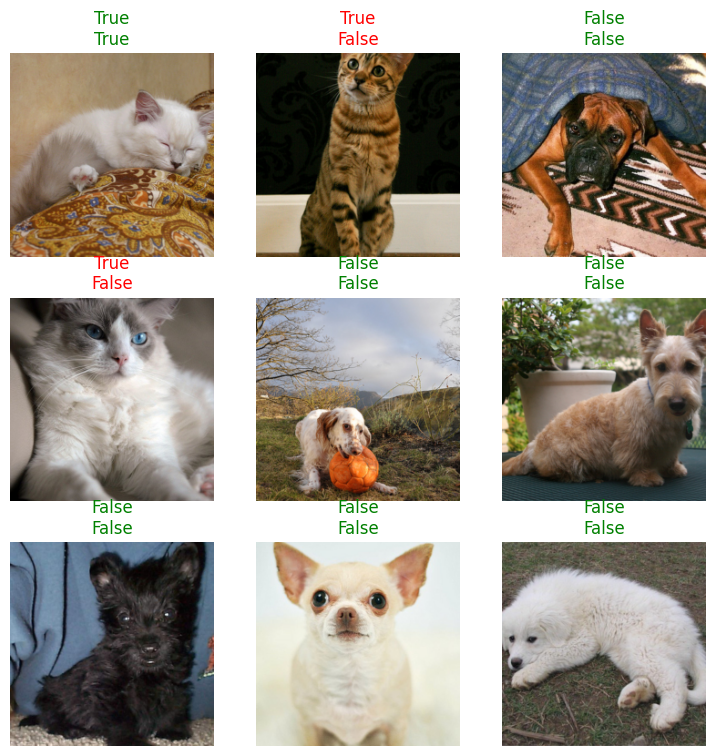

In [26]:
learn.show_results()

In [28]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

<div><progress max="1637796771" value="1637801984"></progress> 100.00% [1637801984/1637796771 00:25&lt;00:00]</div>

[Path('/root/.fastai/data/pascal_2007/train'), Path('/root/.fastai/data/pascal_2007/test.csv'), Path('/root/.fastai/data/pascal_2007/train.csv'), Path('/root/.fastai/data/pascal_2007/test.json'), Path('/root/.fastai/data/pascal_2007/test'), Path('/root/.fastai/data/pascal_2007/segmentation'), Path('/root/.fastai/data/pascal_2007/train.json'), Path('/root/.fastai/data/pascal_2007/valid.json')]

The information about the labels of each image is in the file named `train.csv`. We load it using pandas:

In [29]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


So, what exactly multi-label classification means? That's pretty straightforward: for each filename, we will get the different labels (separated by space) and the last column tells if it's in the validation set or not. To get this in `DataLoaders` quickly, we have a factory method, `from_df`. We can specify the underlying path where all the images are, an additional folder to add between the base path and the filenames (here `train`), the `valid_col` to consider for the validation set (if we don't specify this, we take a random subset), a `label_delim` to split the labels and, as before, `item_tfms` and `batch_tfms`.

Note that we don't have to specify the `fn_col` and the `label_col` because they default to the first and second column respectively.

In [30]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

/usr/local/lib/python3.12/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


As before, we can then have a look at the data with the `show_batch` method.

/usr/local/lib/python3.12/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


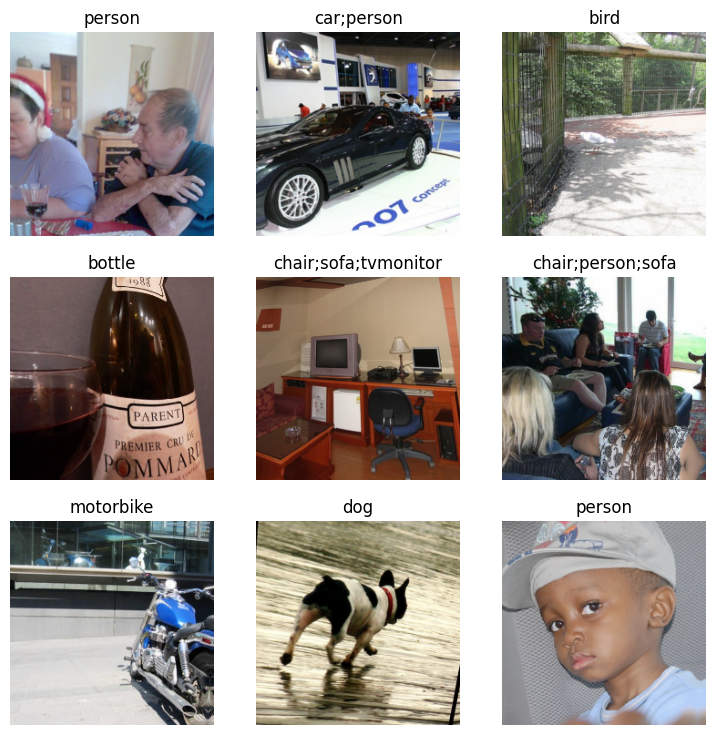

In [31]:
dls.show_batch()

Training a model is as easy (but takes a lot of time, depending on GPU) as before: the same functions can be applied and the fastai library will automatically detect that we are in a multi-label problem, thus picking the right loss function. The only difference is in the metric we pass: `error_rate` will not work for a multi-label problem, but we can use `accuracy_thresh`.

In [32]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

/usr/local/lib/python3.12/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


As before, we can use `learn.lr_find` to pick a good learning rate:

We can pick the suggested learning rate and fine-tune our pretrained model:

In [ ]:
learn.fine_tune(2, 3e-2)

Like before, we can easily have a look at the results:

In [ ]:
learn.show_results()

Or get the predictions on a given image:

In [ ]:
learn.predict(path/'train/000005.jpg')

As for the single classification predictions, we get three things. The last one is the prediction of the model on each class (going from 0 to 1). The second to last cooresponds to a one-hot encoded targets (you get `True` for all predicted classes, the ones that get a probability > 0.5) and the first is the decoded, readable version.

And like before, we can check where the model did its worse:

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)